# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 1. Часть 2: полносвязные нейронные сети. 

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этой части мы будем использовать фреймворк для обучения нейронный сетей, который вы реализовали в первой половине задания. А именно, вам предстоит обучить полносвязную нейронную сеть для предсказания года выпуска песни по ее аудио-признакам. Для этого мы будем использовать [Million Songs Dataset](https://samyzaf.com/ML/song_year/song_year.html). Если по какой-то причине вы не сделали первую половину домашки, то **можете поставить все эксперименты на PyTorch**, но рекомендуется использовать ваши реализации модулей. 

In [ ]:
%load_ext autoreload
%autoreload 2
import modules as mm
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from IPython.display import clear_output

plt.rcParams.update({'font.size': 16})
sns.set_style('whitegrid')
np.random.seed(0xFA1AFE1)

Начнем с того, что скачаем и загрузим данные:

In [ ]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2022-10-23 18:38:23--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  19.2MB/s    in 12s     

2022-10-23 18:38:35 (17.5 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [ ]:
df = pd.read_csv('data.txt.zip', header=None)

Посмотрим на статистики по данным.

In [ ]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,81,82,83,84,85,86,87,88,89,90
count,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,...,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000,515345.000000
mean,1998.397082,43.387126,1.289554,8.658347,1.164124,-6.553601,-9.521975,-2.391089,-1.793236,3.727876,...,15.755406,-73.461500,41.542422,37.934119,0.315751,17.669213,-26.315336,4.458641,20.035136,1.329105
std,10.931046,6.067558,51.580351,35.268585,16.322790,22.860785,12.857751,14.571873,7.963827,10.582861,...,32.099635,175.618889,122.228799,95.050631,16.161764,114.427905,173.977336,13.346557,185.558247,22.088576
min,1922.000000,1.749000,-337.092500,-301.005060,-154.183580,-181.953370,-81.794290,-188.214000,-72.503850,-126.479040,...,-437.722030,-4402.376440,-1810.689190,-3098.350310,-341.789120,-3168.924570,-4319.992320,-236.039260,-7458.378150,-381.424430
25%,1994.000000,39.954690,-26.059520,-11.462710,-8.487500,-20.666450,-18.440990,-10.780600,-6.468420,-2.293660,...,-1.812650,-139.555160,-20.986900,-4.669540,-6.781590,-31.580610,-101.530300,-2.566090,-59.509270,-8.820210
50%,2002.000000,44.258500,8.417850,10.476320,-0.652840,-6.007770,-11.188390,-2.046670,-1.736450,3.822310,...,9.171850,-53.090060,28.791060,33.623630,0.820840,15.598470,-21.204120,3.117640,7.759730,0.053050
75%,2006.000000,47.833890,36.124010,29.764820,8.787540,7.741870,-2.388960,6.508580,2.913450,9.961820,...,26.274480,13.478730,89.661770,77.785800,8.470990,67.794960,52.389330,9.967740,86.351610,9.679520
max,2011.000000,61.970140,384.065730,322.851430,335.771820,262.068870,166.236890,172.402680,126.741270,146.297950,...,840.973380,4469.454870,3210.701700,1734.079690,260.544900,3662.065650,2833.608950,463.419500,7393.398440,677.899630


Целевая переменная, год выпуска песни, записана в первом столбце. Посмотрим на ее распределение.

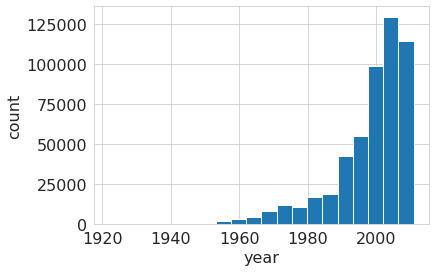

Range: 1922 - 2011
Unique values: 89


In [ ]:
plt.hist(df.iloc[:, 0], bins=20)
plt.xlabel('year')
plt.ylabel('count')
plt.show()
print(f'Range: {df.iloc[:, 0].min()} - {df.iloc[:, 0].max()}')
print(f'Unique values: {np.unique(df.iloc[:, 0]).size}')

Разобьем данные на обучение и тест (не меняйте здесь ничего, чтобы сплит был одинаковым у всех).

In [ ]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = int(0.75 * X.shape[0])
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]
X_train.shape, X_test.shape

((386508, 90), (128837, 90))

**Задание 0 (0 баллов, но при невыполнении максимальная оценка за всю работу &mdash; 0 баллов).** Мы будем использовать MSE как метрику качества. Прежде чем обучать нейронные сети, нам нужно проверить несколько простых бейзлайнов, чтобы было с чем сравнить более сложные алгоритмы. Для этого обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
# from sklearn.preprocessing import StandardScaler


# scaler = StandardScaler()
# scaler.fit(X_train)
# X_train_norm = scaler.fit_transform(X_train)
# X_test_norm = scaler.fit_transform(X_test)
alphas = np.logspace(-10, 5, 100)
errors = []
for alpha in alphas:
    ridge = Ridge(alpha=alpha)
    ridge.fit(X_train, y_train)
    y_pred = ridge.predict(X_test)
    errors.append(mean_squared_error(y_test, y_pred))
best_alpha = min(zip(errors, alphas))[1]

Text(0, 0.5, 'MSE')

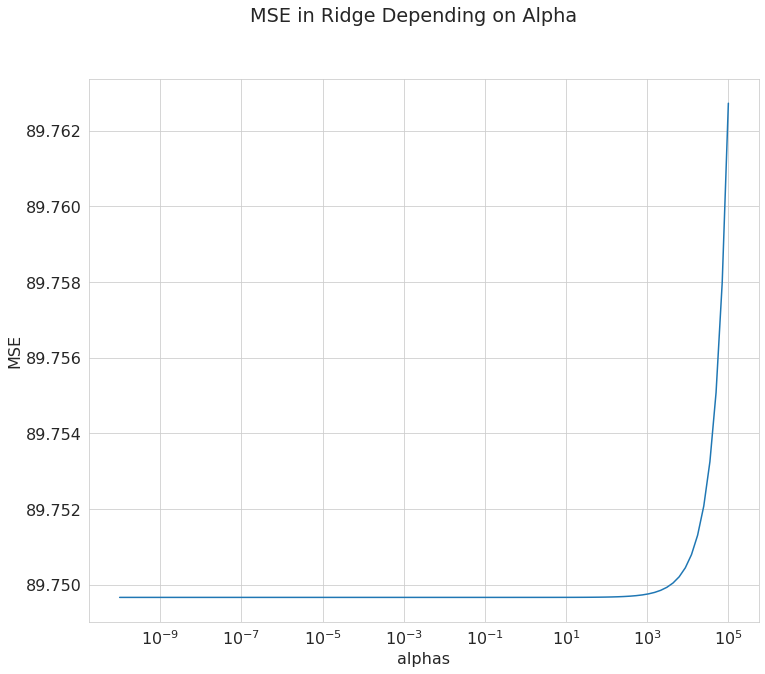

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.suptitle("MSE in Ridge Depending on Alpha")
plt.plot(alphas, errors)
plt.xscale('log')
ax.set_xlabel("alphas")
ax.set_ylabel("MSE")

In [ ]:
ridge = Ridge(alpha=best_alpha)
ridge.fit(X_train, y_train)
y_pred = ridge.predict(X_test)
print(f"Ridge MSE: {mean_squared_error(y_test, y_pred)}")
y_pred = np.full(y_test.shape, y_train.mean())
print(f"MSE of Best Constant Model: {mean_squared_error(y_test, y_pred)}")

Ridge MSE: 89.74966388639828
MSE of Best Constant Model: 117.62580230734426


Теперь приступим к экспериментам с нейросетями. Для начала отделим от данных валидацию:

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=0xE2E4)
X_train.shape, X_val.shape

((289881, 90), (96627, 90))

## Глава I. Заводим нейронную сеть (5 баллов)

**Задание 1.1 (0.5 баллов).** Заполните пропуски в функции `train_and_validate`. Она поможет нам запускать эксперименты.

In [ ]:
def plot_losses(train_losses, train_metrics, val_losses, val_metrics):
    '''
    Plot losses and metrics while training
      - train_losses: sequence of train losses
      - train_metrics: sequence of train MSE values
      - val_losses: sequence of validation losses
      - val_metrics: sequence of validation MSE values
    '''
    clear_output()
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    axs[0].plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs[0].plot(range(1, len(val_losses) + 1), val_losses, label='val')
    axs[1].plot(range(1, len(train_metrics) + 1), train_metrics, label='train')
    axs[1].plot(range(1, len(val_metrics) + 1), val_metrics, label='val')

    if max(train_losses) / min(train_losses) > 10:
        axs[0].set_yscale('log')

    if max(train_metrics) / min(train_metrics) > 10:
        axs[0].set_yscale('log')

    for ax in axs:
        ax.set_xlabel('epoch')
        ax.legend()

    axs[0].set_ylabel('loss')
    axs[1].set_ylabel('MSE')
    plt.show()


def train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader,
                       num_epochs, verbose=True):
    '''
    Train and validate neural network
      - model: neural network (mm.Module) to train
      - optimizer: optimizer (mm.Optimizer) chained to a model
      - criterion: loss function class (mm.Criterion)
      - metrics: function to measure MSE taking neural networks predictions
                 and ground truth labels
      - train_loader: mm.DataLoader with train set
      - val_loader: mm.DataLoader with validation set
      - num_epochs: number of epochs to train
      - verbose: whether to plot metrics during training
    Returns:
      - train_mse: training MSE over the last epoch
      - val_mse: validation MSE after the last epoch
    '''
    train_losses, val_losses = [], []
    train_metrics, val_metrics = [], []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss, running_metric = 0, 0
        pbar = tqdm(train_loader, desc=f'Training {epoch}/{num_epochs}') \
                if verbose else train_loader

        for X_batch, y_batch in pbar:
            '''
            YOUR CODE HERE
            Do forward and backward passes
            predictions = ...
            loss = ...
            '''
            optimizer.zero_grad()
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch) 
            model.backward(X_batch, criterion.backward(predictions, y_batch))
            optimizer.step()
            '''
            END OF YOUR CODE
            '''
            metric_value = metric(predictions, y_batch)
            running_loss += loss * X_batch.shape[0]
            running_metric += metric_value * X_batch.shape[0]
            if verbose:
                pbar.set_postfix({'loss': loss, 'MSE': metric_value})

        train_losses += [running_loss / train_loader.num_samples()]
        train_metrics += [running_metric / train_loader.num_samples()]

        model.eval()
        running_loss, running_metric = 0, 0
        pbar = tqdm(val_loader, desc=f'Validating {epoch}/{num_epochs}') \
                if verbose else val_loader

        for X_batch, y_batch in pbar:
            '''
            YOUR CODE HERE
            Do evaluation
            predictions = ...
            loss = ...
            '''
            predictions = model(X_batch)
            loss = criterion(predictions, y_batch)
            '''
            END OF YOUR CODE
            '''
            metric_value = metric(predictions, y_batch)
            running_loss += loss * X_batch.shape[0]
            running_metric += metric_value * X_batch.shape[0]
            if verbose:
                pbar.set_postfix({'loss': loss, 'MSE': metric_value})

        val_losses += [running_loss / val_loader.num_samples()]
        val_metrics += [running_metric / val_loader.num_samples()]

        if verbose:
            plot_losses(train_losses, train_metrics, val_losses, val_metrics)
    
    if verbose:
        print(f'Validation MSE: {val_metrics[-1]:.3f}')
    
    return train_metrics[-1], val_metrics[-1]

In [ ]:
y_train_orig = y_train
y_val_orig = y_val
y_test_orig = y_test

In [ ]:
# transform target into range(0, C)
MIN_TARGET = 1922
y_train = y_train - MIN_TARGET
y_val = y_val - MIN_TARGET
y_test = y_test - MIN_TARGET

# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_val = scaler.fit_transform(X_val)
# X_test = scaler.fit_transform(X_test)

**Задание 1.2 (0.75 балла).** Попробуем обучить нашу первую нейронную сеть. Здесь целевая переменная дискретная &mdash; это год выпуска песни. Поэтому будем учить сеть на классификацию.

- В качестве архитектуры сети возьмите два линейных слоя с активацией ReLU между ними c числом скрытых нейронов, равным 128.
- Используйте SGD с `lr=1e-3`.
- Возьмите размер мини-батча около 32-64, примерно 3-4 эпох обучения должно быть достаточно.
- Также преобразуйте целевую переменную так, чтобы ее значения принимали значения от $0$ до $C-1$, где $C$ &mdash; число классов (лучше передайте преобразованное значение в DataLoader, исходное нам еще пригодится)
- В качестве параметра `metric` в `train_and_validate` передайте lambda-выражение, которое считает MSE по выходу нейронной сети и целевой переменной. В случае классификации предсказывается класс с наибольшей вероятностью (или, что то же самое, с наибольшим значением логита).

***КОРОЧЕ***: Я тут долго пытался запустить и у меня было loss=0 и mse=6000, 
и я не мог понять, что у меня падает и почему модель не учится. 
С кросс-энтропией (классификация) падает, а с МСЕ-лосс (регрессия) работает.
Поэтому я решил устранить деление на Softmax в методе compute_grad_input у LogSoftmax. 
И всё стало работать.
Я назвал эти ~костыли~ подправленные классы CrossEntropy2 и LogSoftmax2. Только не бейте

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 4
NUM_HIDDEN_NEURONS = 128
LR = 1e-3

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_CLASSES)
)
optimizer = mm.SGD(model, lr=LR)
criterion = mm.CrossEntropyLoss2()
metric = (lambda y_pred, y_true: mean_squared_error(y_true, np.argmax(y_pred, axis=1)))
train_loader = mm.DataLoader(X_train, y_train, batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val, batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS

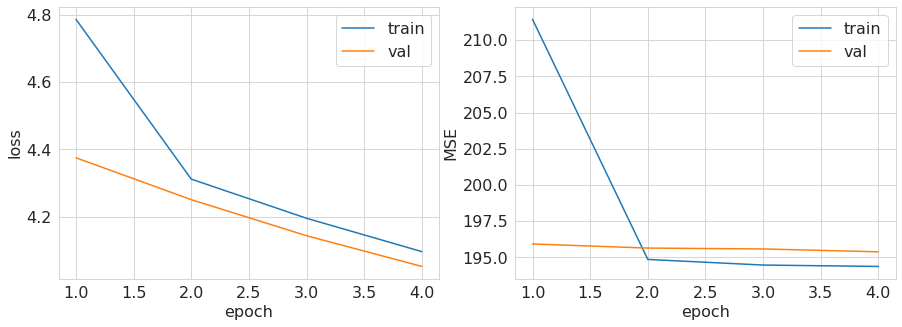

Validation MSE: 195.380


(194.36976552447385, 195.37956264812112)

In [ ]:
train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs)

**Задание 1.3 (0.5 балла).** Прокомментируйте ваши наблюдения. Удалось ли побить бейзлайн? Как вы думаете, хорошая ли идея учить классификатор для этой задачи? Почему?

**Ответ:** Бейслайн не был достигнут. Тут очень много (90) классов и поэтому модель чаще ошибается.

**Задание 1.4 (0.75 балла).** Теперь попробуем решать задачу как регрессию. Обучите нейронную сеть на MSE.

- Используйте такие же гиперпараметры обучения.
- Когда передаете целевую переменную в DataLoader, сделайте reshape в (-1, 1).
- Не забудьте изменить lambda-выражение, которые вы передаете в `train_and_validate`.
- Если что-то пойдет не так, можете попробовать меньшие значения `lr`.

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 4
NUM_HIDDEN_NEURONS = 128
LR = 1e-6

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, 1)
)
optimizer = mm.SGD(model, lr=LR)
criterion = mm.MSELoss()
metric = (lambda y_pred, y_true: mean_squared_error(y_true, y_pred))
train_loader = mm.DataLoader(X_train, y_train.reshape(-1, 1), batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val.reshape(-1, 1), batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS

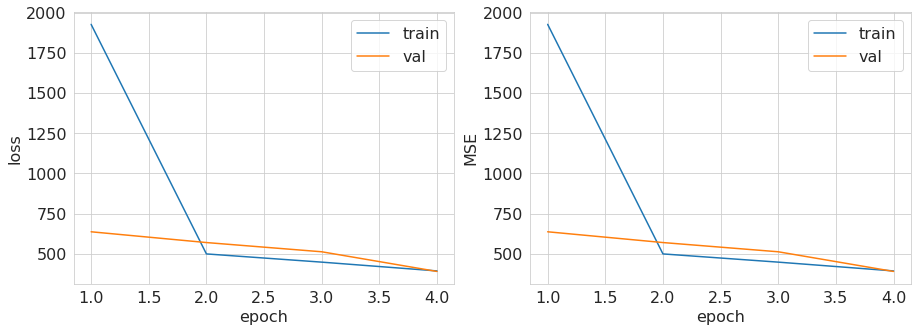

Validation MSE: 389.848


(393.0619206759694, 389.8484617318173)

In [ ]:
train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs)

**Задание 1.5 (0.5 балла).** Получилось ли у вас стабилизировать обучение? Помогли ли меньшие значения `lr`? Стало ли лучше от замены классификации на регрессию? Как вы думаете, почему так происходит? В качестве подсказки можете посмотреть на распределение целевой переменной и магнитуду значений признаков.

**Ответ:** Не получилось. Поменьше `lr` помог, но ошибка всё равно большая. Регрессия в этом оказалась хуже, чем классификация. Это можно объяснить так: классификация штрафует неугаданную целевую переменную слабее, чем регрессия. А у нас тут разница между годами минимум 1. Поэтому лучше отмасштабировать признаки и целевую переменную. Я собственно так и сделал изначально, когда в первом задании нас попросили обучить обычный ридж. Априори очевидно, что на отскейленных данных модель лучше обучится. Меня удивило, что тут это вводится в середине задания. 

**Задание 1.6 (0.75 балла).** Начнем с того, что попробуем отнормировать целевую переменную. Для этого воспользуемся min-max нормализацией, чтобы целевая переменная принимала значения от 0 до 1. Реализуйте функции `normalize` и `denormalize`, которые, соответственно, нормируют целевую переменную и применяют обратное преобразование. Минимум и максимум оцените по обучающей выборке (то есть эти константы должны быть фиксированными и не зависеть от передаваемой выборки).

In [ ]:
TARGET_MIN = y_train_orig.min()
TARGET_MAX = y_train_orig.max()


def normalize(sample):
    '''
    Min-max normalization to convert sample to [0, 1] range
    '''
    return (sample - TARGET_MIN) / (TARGET_MAX - TARGET_MIN)

def denormalize(sample):
    '''
    Denormalize sample from [0, 1] to initial range
    '''
    return sample * (TARGET_MAX - TARGET_MIN) + TARGET_MIN

Теперь повторите эксперимент из **задания 1.4**, обучаясь на нормированной целевой переменной. Сделаем также еще одно изменение: добавим сигмоидную активацию после последнего линейного слоя сети. Таким образом мы гарантируем, что нейронная сеть предсказывает числа из промежутка $[0, 1]$. Использование активации - довольно распространенный прием, когда мы хотим получить числа из определенного диапазона значений. 

In [ ]:
y_train_normalized = normalize(y_train_orig)
y_val_normalized = normalize(y_val_orig)

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 4
NUM_HIDDEN_NEURONS = 128
LR = 1e-3

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, 1),
    mm.Sigmoid()
)
optimizer = mm.SGD(model, lr=LR)
criterion = mm.MSELoss()
metric = lambda y_true, y_pred: mean_squared_error(denormalize(y_true), denormalize(y_pred))
train_loader = mm.DataLoader(X_train, y_train_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS

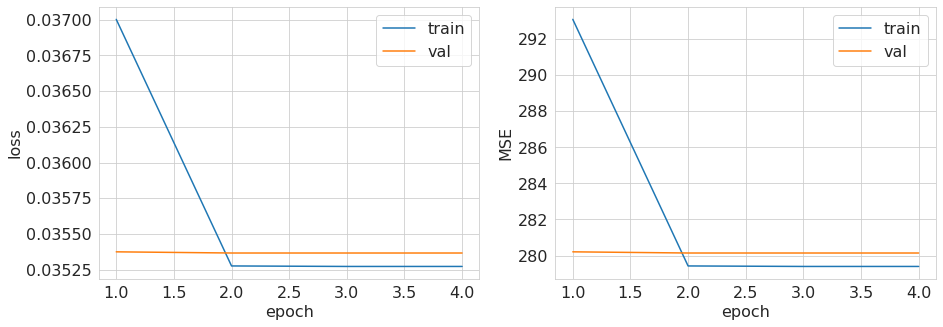

Validation MSE: 280.140


(279.3950852349432, 280.14004672123644)

In [ ]:
train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs)

**Задание 1.7 (0.5 балла).** Сравните результаты этого эксперимента с предыдущим запуском. 

**Ответ:** Учится лучше чем раньше, но сильно хуже чем обычный ридж. А ещё со второй эпохи как будто вообще перестала учиться.

**Задание 1.8 (0.75 балла).** На этот раз попробуем отнормировать не только целевую переменную, но и сами данные, которые подаются сети на вход. Для них будем использовать нормализацию через среднее и стандартное отклонение. Преобразуйте данные и повторите прошлый эксперимент. Скорее всего, имеет смысл увеличить число эпох обучения.

In [ ]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.fit_transform(X_val)
X_test = scaler.fit_transform(X_test)

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 20
NUM_HIDDEN_NEURONS = 128
LR = 1e-4

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, 1),
    mm.Sigmoid()
)
optimizer = mm.SGD(model, lr=LR)
criterion = mm.MSELoss()
metric = lambda y_true, y_pred: mean_squared_error(denormalize(y_true), denormalize(y_pred))
train_loader = mm.DataLoader(X_train, y_train_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS

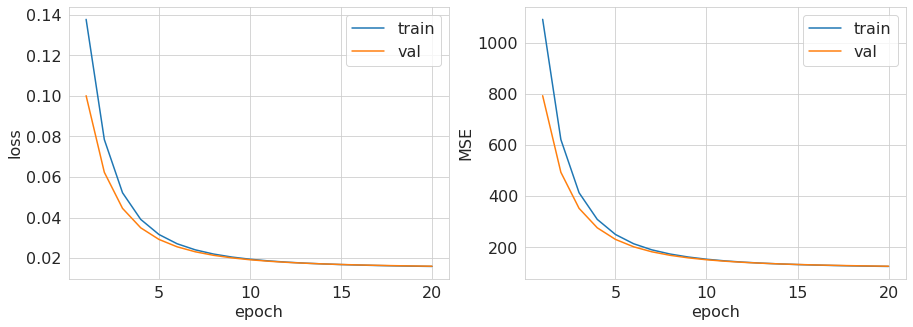

Validation MSE: 126.623


(125.75314774638912, 126.62256526406642)

In [ ]:
train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs)

Если вы все сделали правильно, то у вас должно было получиться качество, сравнимое с `Ridge` регрессией.

**Мораль:** как видите, нам пришлось сделать очень много хитрых телодвижений, чтобы нейронная сеть работала хотя бы так же, как и простая линейная модель. Здесь, конечно, показан совсем экстремальный случай, когда без нормализации данных нейронная сеть просто не учится. Как правило, в реальности завести нейронную сеть из коробки не очень сложно, но вот заставить ее работать на полную &mdash; куда более трудоемкая задача. Написание пайплайнов обучения нейросетевых моделей требует большой аккуратности, а дебаг часто превращается в угадайку. К счастью, очень часто на помощь приходит интуиция, и мы надеемся, что вы сможете выработать ее в течение нашего курса. Начнем с двух советов, которые стоит принять на вооружение:

- Обязательно начинаем любые эксперименты с бейзлайнов: без них мы бы не поняли, что нейронная сеть не учится в принципе.
- При постановке эксперментов старайтесь делать минимальное количество изменений за раз (в идеале одно!): только так можно понять, какие конкретно изменения влияют на результат.

## Часть 2. Улучшаем нейронную сеть

Продолжим экспериментировать с нейронной сетью, чтобы добиться еще лучшего качества.

**Задание 2.1 (1 балл).** Давайте попробуем другие оптимизаторы. Обучите нейросеть с помощью SGD+momentum и Adam. Опишите свои наблюдения и в дальнейших запусках используйте лучший оптимизатор. Для Adam обычно берут learning rate поменьше, в районе $10^{-3}$.

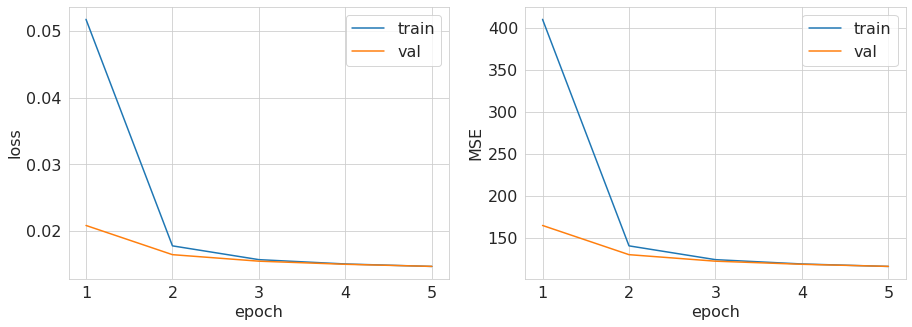

Validation MSE: 116.255


(116.17835457393325, 116.25520792411047)

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 5
NUM_HIDDEN_NEURONS = 128
LR = 1e-4

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, 1),
    mm.Sigmoid()
)
optimizer = mm.SGD(model, lr=LR, momentum=0.9)
criterion = mm.MSELoss()
metric = lambda y_true, y_pred: mean_squared_error(denormalize(y_true), denormalize(y_pred))
train_loader = mm.DataLoader(X_train, y_train_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS
train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs)

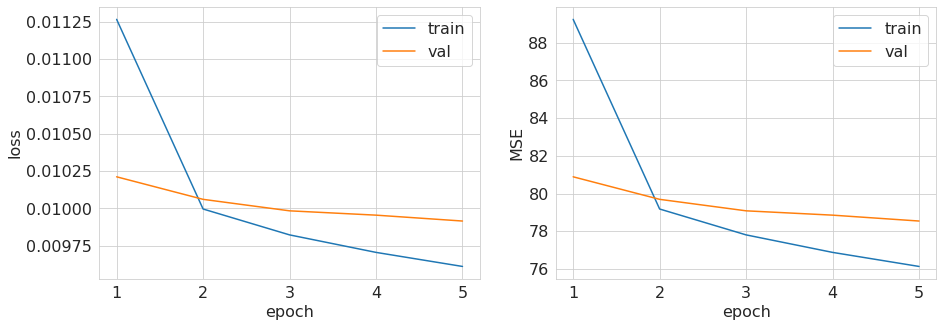

Validation MSE: 78.540


(76.12999669535796, 78.53981323915355)

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 5
NUM_HIDDEN_NEURONS = 128
LR = 1e-3

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, 1),
    mm.Sigmoid()
)
optimizer = mm.Adam(model)
criterion = mm.MSELoss()
metric = lambda y_true, y_pred: mean_squared_error(denormalize(y_true), denormalize(y_pred))
train_loader = mm.DataLoader(X_train, y_train_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS
train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs)

**Адам обучился лучше чем ридж :)** Юзаем его

**Задание 2.2 (1 балл).** Теперь сделаем нашу нейронную сеть более сложной. Попробуйте сделать сеть:

- более широкой (то есть увеличить размерность скрытого слоя, например, вдвое)
- более глубокой (то есть добавить еще один скрытый слой)

Опишите, как увеличение числа параметров модели влияет на качество на обучающей и валидационной выборках.

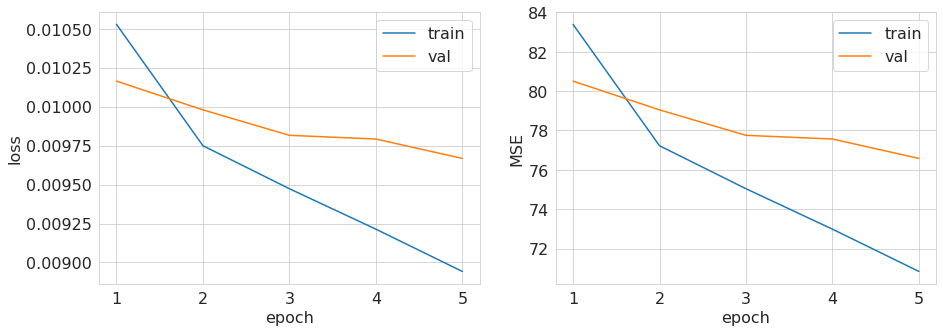

Validation MSE: 76.580


(70.8340723213628, 76.57981849656838)

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 5
NUM_HIDDEN_NEURONS = 256
LR = 1e-4

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, 1),
    mm.Sigmoid()
)
optimizer = mm.Adam(model)
criterion = mm.MSELoss()
metric = lambda y_true, y_pred: mean_squared_error(denormalize(y_true), denormalize(y_pred))
train_loader = mm.DataLoader(X_train, y_train_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS
train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs)

**Ответ**: Я бы не сказал, что она супер сильно переобучилась, но переобучение заметно - на трейне ошибка ниже, чем в прошлый раз, а на вале - почти такая же.

**Задание 2.3 (1 балл).** Как вы должны были заметить, более сложная модель стала сильнее переобучаться. Попробуем разные методы регуляризации, чтобы бороться с переобучением. Проведите два эксперимента:

- Добавьте слой дропаута с параметром $p=0.2$ после каждого линейного слоя, кроме последнего.
- Попробуйте batch-нормализацию вместо дропаута. Строго говоря, batch-нормализация не является методом регуляризации, но никто не запрещает нам экспериментировать с ней.

Опишите результаты экспериментов. 

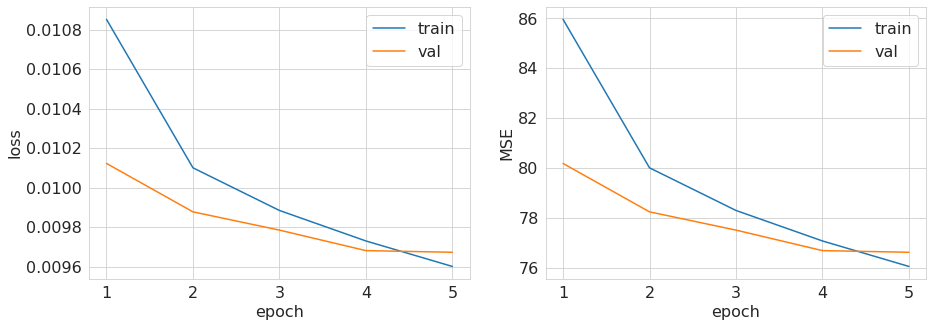

Validation MSE: 76.617


(76.0484905751653, 76.61698104589212)

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 5
NUM_HIDDEN_NEURONS = 256
LR = 1e-4

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.Dropout(p=0.2),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.Dropout(p=0.2),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.Dropout(p=0.2),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, 1),
    mm.Sigmoid()
)
optimizer = mm.Adam(model)
criterion = mm.MSELoss()
metric = lambda y_true, y_pred: mean_squared_error(denormalize(y_true), denormalize(y_pred))
train_loader = mm.DataLoader(X_train, y_train_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS
train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs)

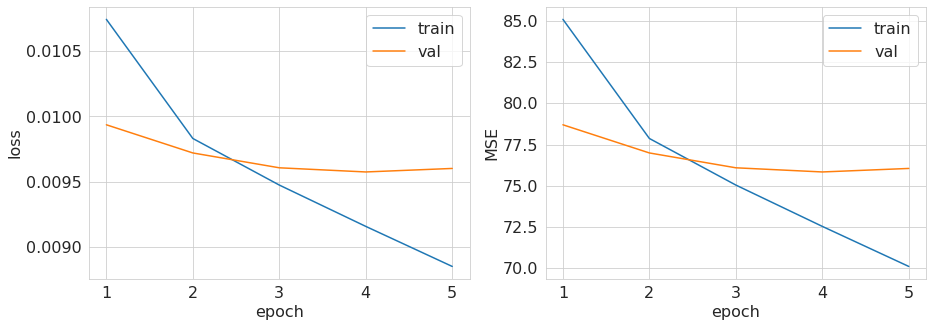

Validation MSE: 76.049


(70.10652212063262, 76.04907399924831)

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 5
NUM_HIDDEN_NEURONS = 256
LR = 1e-4

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, 1),
    mm.Sigmoid()
)
optimizer = mm.Adam(model)
criterion = mm.MSELoss()
metric = lambda y_true, y_pred: mean_squared_error(denormalize(y_true), denormalize(y_pred))
train_loader = mm.DataLoader(X_train, y_train_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS
train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs)

**Задание 2.4 (1.5 балла).** Теперь, когда мы определились с выбором архитектуры нейронной сети, пора заняться рутиной DL-инженера &mdash; перебором гиперпараметров. Подберите оптимальное значение lr по значению MSE на валидации (по логарифмической сетке, достаточно посмотреть 3-4 значения), можете воспользоваться `verbose=False` в функции `train_and_validate`. Затем подберите оптимальное значение weight decay для данного lr (тоже по логарифмической сетке, типичные значения этого параметра лежат в диапазоне $[10^{-6}, 10^{-3}]$, но не забудьте включить нулевое значение в сетку). Постройте графики зависимости MSE на трейне и на валидации от значений параметров. Прокомментируйте получившиеся зависимости.

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 5
NUM_HIDDEN_NEURONS = 256
# LR = 1e-4

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, 1),
    mm.Sigmoid()
)
optimizer = mm.Adam(model, lr=LR)
criterion = mm.MSELoss()
metric = lambda y_true, y_pred: mean_squared_error(denormalize(y_true), denormalize(y_pred))
train_loader = mm.DataLoader(X_train, y_train_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS
errors = []
for LR in np.logspace(-6, -3, 3):
    optimizer = mm.Adam(model, lr=LR)
    errors += [train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs, 
                                  verbose=False)]

In [ ]:
errors # best lr = 1e-3

[(99.85146026218958, 96.85777116169254),
 (71.30800474132003, 79.17200248365927),
 (69.39645319277369, 75.74830338786366)]

In [ ]:
val_errors = [e[1] for e in errors]

Text(0, 0.5, 'MSE')

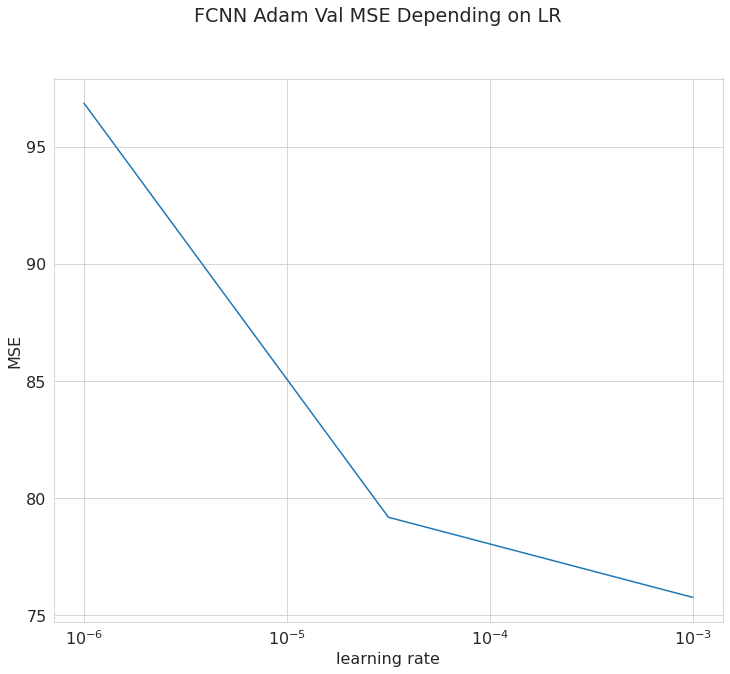

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.suptitle("FCNN Adam Val MSE Depending on LR")
plt.plot(np.logspace(-6, -3, 3), val_errors)
plt.xscale('log')
ax.set_xlabel("learning rate")
ax.set_ylabel("MSE")

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 5
NUM_HIDDEN_NEURONS = 256
LR = 1e-3

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, 1),
    mm.Sigmoid()
)
optimizer = mm.Adam(model, lr=LR)
criterion = mm.MSELoss()
metric = lambda y_true, y_pred: mean_squared_error(denormalize(y_true), denormalize(y_pred))
train_loader = mm.DataLoader(X_train, y_train_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS
errors2 = []
for WEIGHT_DECAY in (list(np.logspace(-6, -3, 3)) + [0]):
    optimizer = mm.Adam(model, lr=LR, weight_decay=WEIGHT_DECAY)
    errors2 += [train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs, 
                                  verbose=False)]

In [ ]:
errors2 # best weight_decay = 1e-6

[(72.56429279066381, 75.78781351146216),
 (77.93078449032822, 78.38184042523854),
 (84.10794874614402, 83.51999083919118),
 (79.28383200607055, 79.42233187302757)]

In [ ]:
val_errors2 = [e[1] for e in errors2]

Text(0, 0.5, 'MSE')

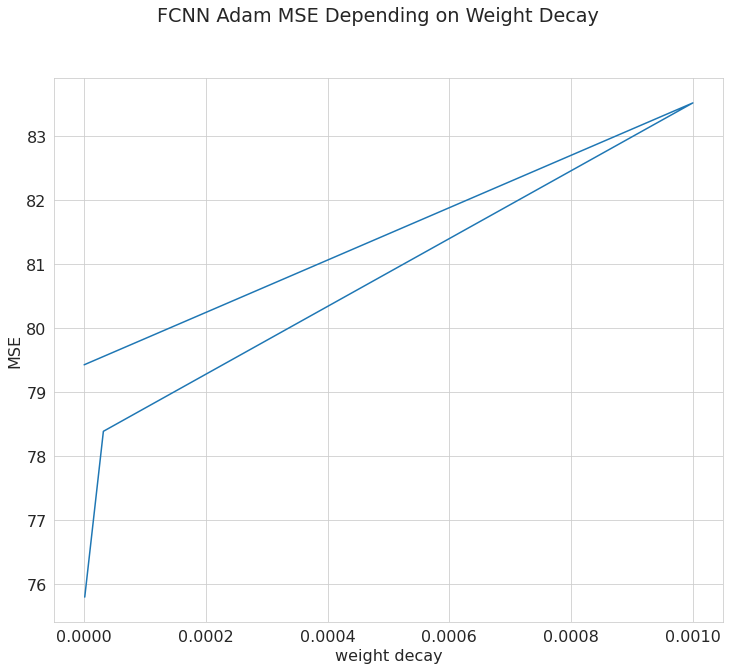

In [ ]:
fig, ax = plt.subplots(figsize=(12, 10))
fig.suptitle("FCNN Adam MSE Depending on Weight Decay")
plt.plot(list(np.logspace(-6, -3, 3)) + [0], val_errors2)
ax.set_xlabel("weight decay")
ax.set_ylabel("MSE")

Как вы могли заметить, еще одна рутина DL-инженера &mdash; утомительное ожидание обучения моделей.

**Задание 2.5 (0.5 балла).** Мы провели большое число экспериментов и подобрали оптимальную архитектуру и гиперпараметры. Пришло время обучить модель на полной обучающей выборке, померять качество на тестовой выборке и сравнить с бейзлайнами. Проделайте это. 

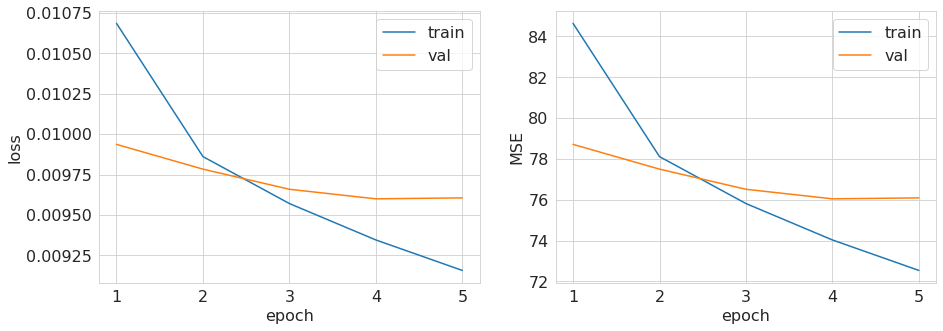

Validation MSE: 76.091


(72.53659768812886, 76.09142740289623)

In [ ]:
BATCH_SIZE = 64
NUM_FEATURES = X_train.shape[1]
NUM_CLASSES = 90
NUM_EPOCHS = 5
NUM_HIDDEN_NEURONS = 256
LR = 1e-3
WEIGHT_DECAY = 1e-6

model = mm.Sequential(
    mm.Linear(NUM_FEATURES, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, NUM_HIDDEN_NEURONS),
    mm.BatchNormalization(num_features=NUM_HIDDEN_NEURONS),
    mm.ReLU(),
    mm.Linear(NUM_HIDDEN_NEURONS, 1),
    mm.Sigmoid()
)
optimizer = mm.Adam(model, lr=LR, weight_decay=WEIGHT_DECAY)
criterion = mm.MSELoss()
metric = lambda y_true, y_pred: mean_squared_error(denormalize(y_true), denormalize(y_pred))
train_loader = mm.DataLoader(X_train, y_train_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
val_loader = mm.DataLoader(X_val, y_val_normalized.reshape(-1, 1), batch_size=BATCH_SIZE)
num_epochs = NUM_EPOCHS
train_and_validate(model, optimizer, criterion, metric, train_loader, val_loader, num_epochs)